In [2]:
#import datadotworld as dw
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
import pandas as pd
import seaborn as sns
import numpy as np
import math

import xgboost
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## What Ukraine code is
We need this information because documentation says that the fist two letters of station id are the country code.
Though we need ukrainian stations, I decided to simplify further work

In [11]:
#reading data set that contains all country codes
countries = pd.read_fwf('ghcnd-countries.txt', header=None, names=["country_code","country_name"])
ukraine_code = str(countries[countries["country_name"]=="Ukraine"]["country_code"].iloc[0])

## Get only Ukrainian stations

In [12]:
#stations = pd.read_csv('ghcnd-stations.txt', sep=' ', header=None)#, names=[“Column1”, “Column2”])
#stations = pd.read_table('ghcnd-stations.txt', delimiter=" ")



#stations = pd.read_fwf('ghcnd-stations.txt', header=None, names=["id", "latitude","longitude", "elevation", "name","n/d1","n/d2","n/d3"])
stations = pd.read_fwf('ghcnd-stations.txt', header=None, colspecs=[(0,11),(12,20),(21,30),(31,37),(38,40),(41,71),(72,75),(76,79),(80,85)],
                      names=["id", "latitude","longitude", "elevation", "state","name", "gsn","hcn/crn","wmo"])
def f(row):
    if np.isnan(row):
        return str(row)
    else:
        return str(int(row))
stations["wmo"]=stations["wmo"].apply(lambda row: str(row) if np.isnan(row) else str(int(row)))
u_stations = stations[stations["id"].astype(str).str[0:2]==ukraine_code]
u_stations.head()
u_stations.head()

,id,latitude,longitude,elevation,state,name,gsn,hcn/crn,wmo
52531,UPM00033049,52.183,32.583,161.0,NaN,SEMENOVKA,NaN,NaN,33049
52532,UPM00033058,52.050,33.950,190.0,NaN,DRUZHBA,NaN,NaN,33058
52533,UPM00033067,51.500,23.800,164.0,NaN,SVITYAZ',NaN,NaN,33067
52534,UPM00033075,51.800,25.500,149.0,NaN,LUBESHOV,NaN,NaN,33075
52535,UPM00033088,51.300,26.700,153.0,NaN,SARNY,NaN,NaN,33088


## Using Google maps API to find stations in Lviv oblast (already have in lviv_stations.csv)

In [13]:
import re
def get_oblast(result):
    for data in result:
        for component in data["address_components"]:
            x=re.findall(".+(?=Oblast)", component["long_name"])
            if x:
                x=x[0].strip()
                return x

In [14]:

import googlemaps
gmaps = googlemaps.Client(key='your_key')

#test to get the region
reverse = gmaps.reverse_geocode((51.500, 23.800))
oblast = reverse[0]["address_components"][3]["long_name"] #region
#Rivne Oblast
def if_lviv(row):
    reverse = gmaps.reverse_geocode((row["latitude"], row["longitude"]))
    return get_oblast(reverse)=="Lviv"

lviv_stations = u_stations[u_stations.apply(if_lviv, axis=1)]
lviv_stations

,id,latitude,longitude,elevation,state,name,gsn,hcn/crn,wmo
52557,UPM00033287,50.2500,23.633,251.0,NaN,RAVA-RUSKA,NaN,NaN,33287
52558,UPM00033288,50.1000,24.350,228.0,NaN,KAMENKA-BUGSKAYA,NaN,NaN,33288
52560,UPM00033297,50.1000,25.150,228.0,NaN,BRODY,NaN,NaN,33297
52578,UPM00033391,49.8000,23.150,216.0,NaN,MOSTISKA,NaN,NaN,33391
52579,UPM00033392,49.9330,23.383,229.0,NaN,YAVOROV,NaN,NaN,33392
52580,UPM00033393,49.8167,23.950,323.0,NaN,LVIV,NaN,NaN,33393
52581,UPM00033397,49.5000,23.200,302.0,NaN,SAMBOR,NaN,NaN,33397
52582,UPM00033398,49.3500,23.517,276.0,NaN,DROHOBYCH,NaN,NaN,33398
52596,UPM00033511,49.1170,23.033,588.0,NaN,TURKA,NaN,NaN,33511
52597,UPM00033513,49.3000,23.900,294.0,NaN,STPIY,NaN,NaN,33513


In [3]:
lviv_stations = pd.read_csv("lviv_stations.csv")
lviv_stations

,id,latitude,longitude,elevation,state,name,gsn,hcn/crn,wmo
0,UPM00033287,50.2500,23.633,251.0,NaN,RAVA-RUSKA,NaN,NaN,33287
1,UPM00033288,50.1000,24.350,228.0,NaN,KAMENKA-BUGSKAYA,NaN,NaN,33288
2,UPM00033297,50.1000,25.150,228.0,NaN,BRODY,NaN,NaN,33297
3,UPM00033391,49.8000,23.150,216.0,NaN,MOSTISKA,NaN,NaN,33391
4,UPM00033392,49.9330,23.383,229.0,NaN,YAVOROV,NaN,NaN,33392
5,UPM00033393,49.8167,23.950,323.0,NaN,LVIV,NaN,NaN,33393
6,UPM00033397,49.5000,23.200,302.0,NaN,SAMBOR,NaN,NaN,33397
7,UPM00033398,49.3500,23.517,276.0,NaN,DROHOBYCH,NaN,NaN,33398
8,UPM00033511,49.1170,23.033,588.0,NaN,TURKA,NaN,NaN,33511
9,UPM00033513,49.3000,23.900,294.0,NaN,STPIY,NaN,NaN,33513


# Visualization of these stations on the map using ipyleaflet

In [3]:
import ipyleaflet
from ipyleaflet import Map, basemaps, basemap_to_tiles, Marker, CircleMarker, AntPath

### Getting Lviv coordinates

In [4]:
#lviv = gmaps.geocode('Lviv, Ukraine')
#lviv = lviv[0]["geometry"]["location"]# lat lng
#lviv = (lviv["lat"],lviv["lng"])
lviv=(49.839683, 24.029717)

In [5]:
m = ipyleaflet.Map(center = lviv, zoom=7.3, scroll_wheel_zoom=True)
lons = lviv_stations['longitude'].tolist()
lats = lviv_stations['latitude'].tolist()
cordinates = list(zip(lats,lons))
for cor in cordinates:
    temp = CircleMarker()
    temp.location = cor
    m.add_layer(temp)
m

Map(center=[49.839683, 24.029717], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

### Saving to limit unnecessary Google Api Usage

In [20]:
lviv_stations.to_csv("lviv_stations.csv", index=False)


In [21]:
lviv_stations = pd.read_csv("lviv_stations.csv")
lviv_stations

,id,latitude,longitude,elevation,state,name,gsn,hcn/crn,wmo
0,UPM00033287,50.2500,23.633,251.0,NaN,RAVA-RUSKA,NaN,NaN,33287
1,UPM00033288,50.1000,24.350,228.0,NaN,KAMENKA-BUGSKAYA,NaN,NaN,33288
2,UPM00033297,50.1000,25.150,228.0,NaN,BRODY,NaN,NaN,33297
3,UPM00033391,49.8000,23.150,216.0,NaN,MOSTISKA,NaN,NaN,33391
4,UPM00033392,49.9330,23.383,229.0,NaN,YAVOROV,NaN,NaN,33392
5,UPM00033393,49.8167,23.950,323.0,NaN,LVIV,NaN,NaN,33393
6,UPM00033397,49.5000,23.200,302.0,NaN,SAMBOR,NaN,NaN,33397
7,UPM00033398,49.3500,23.517,276.0,NaN,DROHOBYCH,NaN,NaN,33398
8,UPM00033511,49.1170,23.033,588.0,NaN,TURKA,NaN,NaN,33511
9,UPM00033513,49.3000,23.900,294.0,NaN,STPIY,NaN,NaN,33513


# Using Inventory database to check the recording of every element

In [4]:
inventory = pd.read_fwf('ghcnd-inventory.txt', header=None, colspecs=[(0,11),(12,20),(21,30),(31,35),(36,40),(41,45)],
                      names=["id", "latitude","longitude", "element", "first year","last year"])
inventory

,id,latitude,longitude,element,first year,last year
0,ACW00011604,17.1167,-61.7833,TMAX,1949,1949
1,ACW00011604,17.1167,-61.7833,TMIN,1949,1949
2,ACW00011604,17.1167,-61.7833,PRCP,1949,1949
3,ACW00011604,17.1167,-61.7833,SNOW,1949,1949
4,ACW00011604,17.1167,-61.7833,SNWD,1949,1949
...,...,...,...,...,...,...
725645,ZI000067983,-20.2000,32.6160,PRCP,1951,2020
725646,ZI000067983,-20.2000,32.6160,TAVG,1962,2020
725647,ZI000067991,-22.2170,30.0000,TMAX,1951,1990
725648,ZI000067991,-22.2170,30.0000,TMIN,1951,1990


In [5]:
def is_lviv_station(row):
    return row["id"] in list(lviv_stations["id"])
lviv_inventory = inventory[inventory.apply(is_lviv_station, axis=1)]

In [6]:
#lviv_inventory = lviv_inventory.set_index(["id","element"])
lviv_stations_ids = lviv_inventory["id"].unique()
lviv_inventory.set_index(["id","element"])

latitude  longitude  first year  last year
id          element                                            
UPM00033287 TMAX      50.2500     23.633        1959       2016
            TMIN      50.2500     23.633        1959       2016
            PRCP      50.2500     23.633        1961       2016
            SNWD      50.2500     23.633        1973       2016
            TAVG      50.2500     23.633        1959       2022
UPM00033288 TMAX      50.1000     24.350        1959       2009
            TMIN      50.1000     24.350        1959       2009
            PRCP      50.1000     24.350        1959       2009
            SNWD      50.1000     24.350        1978       1998
            TAVG      50.1000     24.350        1959       2009
UPM00033297 TMAX      50.1000     25.150        1959       2016
            TMIN      50.1000     25.150        1959       2016
            PRCP      50.1000     25.150        1959       2016
            SNWD      50.1000     25.150        1973       2016
            TAVG      50.1000     25.150        1959       2022
UPM00033391 TMAX      49.8000     23.150        1959       2009
            TMIN      49.8000     23.150        1959       2009
            PRCP      49.8000     23.150        1959       2009
            SNWD      49.8000     23.150        1978       1998
            TAVG      49.8000     23.150        1959       2009
UPM00033392 TMAX      49.9330     23.383        2000       2009
            TMIN      49.9330     23.383        2000       2009
            PRCP      49.9330     23.383        1959       2009
            TAVG      49.9330     23.383        1990       2009
UPM00033393 TMAX      49.8167     23.950        1936       2022
            TMIN      49.8167     23.950        1936       2022
            PRCP      49.8167     23.950        1936       2022
            SNWD      49.8167     23.950        1973       2022
            TAVG      49.8167     23.950        1936       2022
UPM00033397 PRCP      49.5000     23.200        1959       1988
UPM00033398 TMAX      49.3500     23.517        1959       2016
            TMIN      49.3500     23.517        1959       2016
            PRCP      49.3500     23.517        1941       2016
            SNWD      49.3500     23.517        1973       2016
            TAVG      49.3500     23.517        1959       2022
UPM00033511 TMAX      49.1170     23.033        1955       2016
            TMIN      49.1170     23.033        1955       2016
            PRCP      49.1170     23.033        1945       2016
            SNWD      49.1170     23.033        1973       2016
            TAVG      49.1170     23.033        1955       2016
UPM00033513 TMAX      49.3000     23.900        2000       2009
            TMIN      49.3000     23.900        2000       2009
            PRCP      49.3000     23.900        1960       2009
            TAVG      49.3000     23.900        2000       2009
UPM00033516 TMAX      48.9000     23.500        2000       2009
            TMIN      48.9000     23.500        2000       2009
            PRCP      48.9000     23.500        1946       2009
            TAVG      48.9000     23.500        2000       2009

Now we have some understanding about data recording. Lviv station has the longest period, though I'll use all stations just to get better picture in those years, when most stations were active.
So, sometimes I will get information from particular place, sometimes it will be avarage for all stations.
I'll try to make visualization for Lviv station only too? just to compare.

# Preparing data from the station in convenient form

In [7]:
def get_data_from_station(station):
    #preparing to read(based on documentation)
    cols = [(0,11),(11,15),(15,17),(17,21)]
    names=["id","year","month","element"]
    k=21
    for i in range(31):
        cols.append((k,k+5))
        names.append("day {}".format(i+1))
        names.append("mflag {}".format(i+1))
        names.append("qflag {}".format(i+1))
        names.append("sflag {}".format(i+1))
        k=k+5
        for n in range(3):
            cols.append((k,k+1))
            k=k+1
    dly_lviv = pd.read_fwf("{}.dly.txt".format(station),header=None, colspecs=cols, names=names, na_values=[-9999])
    temp_df = dly_lviv.iloc[:,0:4]
    lviv_data = dly_lviv.iloc[:,4:5]
    lviv_data.columns=["data"]
    lviv_data["day"]=1
    lviv_data= pd.concat([temp_df,lviv_data], axis="columns")
    k=8
    for i in range(30):
        temp = dly_lviv.iloc[:,k:k+1]
        temp.columns=["data"]
        temp["day"]=i+2
        temp = pd.concat([temp_df,temp], axis=1)
        lviv_data = pd.concat([lviv_data,temp], ignore_index=True)
        #dfs.append(temp)
        k=k+4
    lviv_data=lviv_data[["id","year","month","day","element","data"]]
    return lviv_data

In [8]:
lviv_data = get_data_from_station("UPM00033393")
lviv_data

,id,year,month,day,element,data
0,UPM00033393,1936,1,1,TMAX,47.0
1,UPM00033393,1936,1,1,TMIN,21.0
2,UPM00033393,1936,1,1,PRCP,0.0
3,UPM00033393,1936,1,1,TAVG,32.0
4,UPM00033393,1936,2,1,TMAX,52.0
...,...,...,...,...,...,...
130164,UPM00033393,2022,6,31,TAVG,NaN
130165,UPM00033393,2022,7,31,TMAX,NaN
130166,UPM00033393,2022,7,31,TMIN,NaN
130167,UPM00033393,2022,7,31,PRCP,NaN


In [9]:
lviv_stations_ids=list(lviv_stations_ids)
lviv_stations_ids.remove("UPM00033393")
for station in lviv_stations_ids:
    temp=get_data_from_station(station)
    lviv_data=pd.concat([lviv_data,temp], axis=0, ignore_index=True)

In [10]:
lviv_data = lviv_data.dropna()

In [11]:
lviv_data

,id,year,month,day,element,data
0,UPM00033393,1936,1,1,TMAX,47.0
1,UPM00033393,1936,1,1,TMIN,21.0
2,UPM00033393,1936,1,1,PRCP,0.0
3,UPM00033393,1936,1,1,TAVG,32.0
4,UPM00033393,1936,2,1,TMAX,52.0
...,...,...,...,...,...,...
487659,UPM00033516,2008,10,31,TAVG,113.0
487665,UPM00033516,2008,12,31,TMIN,-202.0
487667,UPM00033516,2008,12,31,TAVG,-193.0
487676,UPM00033516,2009,3,31,TMAX,61.0


# Analysis

In [186]:
tavg = lviv_data[lviv_data["element"]=="TAVG"]
tavg = tavg.groupby([tavg["year"],tavg["month"],tavg["day"]]).data.mean().reset_index(name="data")
tavg

,month,day,data
year,,,
1936,366,366,366
1937,365,365,365
1938,365,365,365
1939,212,212,212
1940,184,184,184
...,...,...,...
2018,365,365,365
2019,365,365,365
2020,366,366,366


In [193]:
full_years = tavg.groupby([tavg["year"]]).day.count().reset_index(name="count")
full_years=full_years[full_years["count"]>360]
full_years = list(full_years.year)

In [196]:
tavg = tavg[tavg["year"].isin(full_years)]
tavg

,year,month,day,data
0,1936,1,1,32.000000
1,1936,1,2,30.000000
2,1936,1,3,26.000000
3,1936,1,4,31.000000
4,1936,1,5,19.000000
...,...,...,...,...
29558,2021,12,27,-78.571429
29559,2021,12,28,-48.000000
29560,2021,12,29,-38.666667
29561,2021,12,30,15.000000


In [242]:
#setting new "year" parameter
df=tavg.copy()
df=df[df["year"]>1960]
def new_year(row):
    r = (row//10)*10
    return "{}-{}".format(r,r+9)
df["range"] = df["year"].apply(new_year)
df["data"]=df["data"]*0.1
df

,year,month,day,data,range
7518,1961,1,1,-4.200000,1960-1969
7519,1961,1,2,-2.200000,1960-1969
7520,1961,1,3,-0.200000,1960-1969
7521,1961,1,4,0.300000,1960-1969
7522,1961,1,5,0.400000,1960-1969
...,...,...,...,...,...
29558,2021,12,27,-7.857143,2020-2029
29559,2021,12,28,-4.800000,2020-2029
29560,2021,12,29,-3.866667,2020-2029
29561,2021,12,30,1.500000,2020-2029


In [243]:
ranged = df.groupby([df["range"],df["month"]])["data"].mean().reset_index(name="t")
ranged

,range,month,t
0,1960-1969,1,-6.538099
1,1960-1969,2,-3.793352
2,1960-1969,3,-0.077518
3,1960-1969,4,8.135326
4,1960-1969,5,13.096344
...,...,...,...
79,2020-2029,8,18.758664
80,2020-2029,9,14.017524
81,2020-2029,10,9.584885
82,2020-2029,11,4.323587


<IPython.core.display.Javascript object>


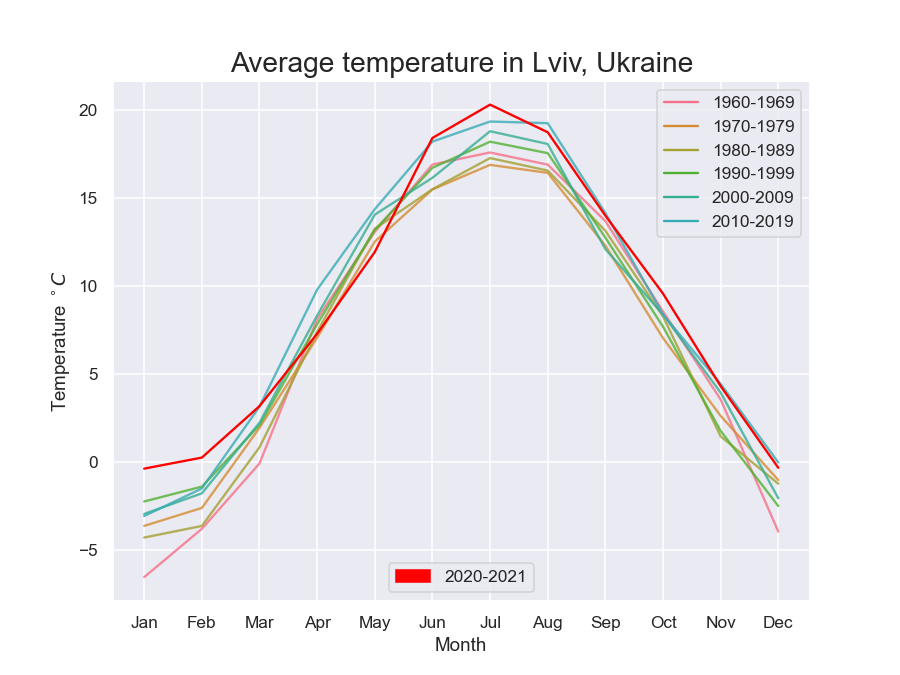

In [252]:
import matplotlib.patches as mpatches

sns.set_theme(style="darkgrid")
sns.set_palette("husl", 9)

fig = plt.figure(figsize=(8,6))
sns.lineplot(x="month",y="t",hue="range", data=ranged[ranged["range"] != "2020-2029"], alpha = 0.8)
plt.xlabel("Month")
plt.ylabel("Temperature $^\circ C$")
plt.title("Average temperature in Lviv, Ukraine", size=18)
new_dates=np.arange(1,13)
plt.xticks(new_dates,["Jan","Feb","Mar",'Apr','May',"Jun",'Jul','Aug','Sep','Oct','Nov','Dec'])
sns.lineplot(x="month", y="t", data=ranged[ranged["range"]=="2020-2029"], color="red")

red_patch = mpatches.Patch(color='red', label='2020-2021')
ax = fig.gca()
first_legend = ax.legend(handles=[red_patch], loc=8)
ax.add_artist(first_legend)
plt.legend()
plt.savefig('lviv.png')

# Forecasting time series

In [12]:
data = lviv_data.copy()
data =  data.groupby([data["year"],data["month"],data["day"], data["element"]]).data.mean().reset_index(name="data")
data

,year,month,day,element,data
0,1936,1,1,PRCP,0.0
1,1936,1,1,TAVG,32.0
2,1936,1,1,TMAX,47.0
3,1936,1,1,TMIN,21.0
4,1936,1,2,PRCP,0.0
...,...,...,...,...,...
114585,2022,7,19,TMAX,255.0
114586,2022,7,19,TMIN,107.0
114587,2022,7,20,TAVG,218.0
114588,2022,7,20,TMAX,300.0


In [13]:
data=data[data["element"]=="TAVG"]
data=data.loc[data["year"]>1949]
data["data"]=data["data"]/10
date = pd.to_datetime(data[["year","month", "day"]])
data.index = date
data[data["month"]==7]

,year,month,day,element,data
1950-07-01,1950,7,1,TAVG,22.6
1950-07-02,1950,7,2,TAVG,20.6
1950-07-03,1950,7,3,TAVG,20.1
1950-07-04,1950,7,4,TAVG,20.2
1950-07-05,1950,7,5,TAVG,18.4
...,...,...,...,...,...
2022-07-16,2022,7,16,TAVG,16.2
2022-07-17,2022,7,17,TAVG,14.9
2022-07-18,2022,7,18,TAVG,16.7
2022-07-19,2022,7,19,TAVG,18.6


## PLot

<IPython.core.display.Javascript object>


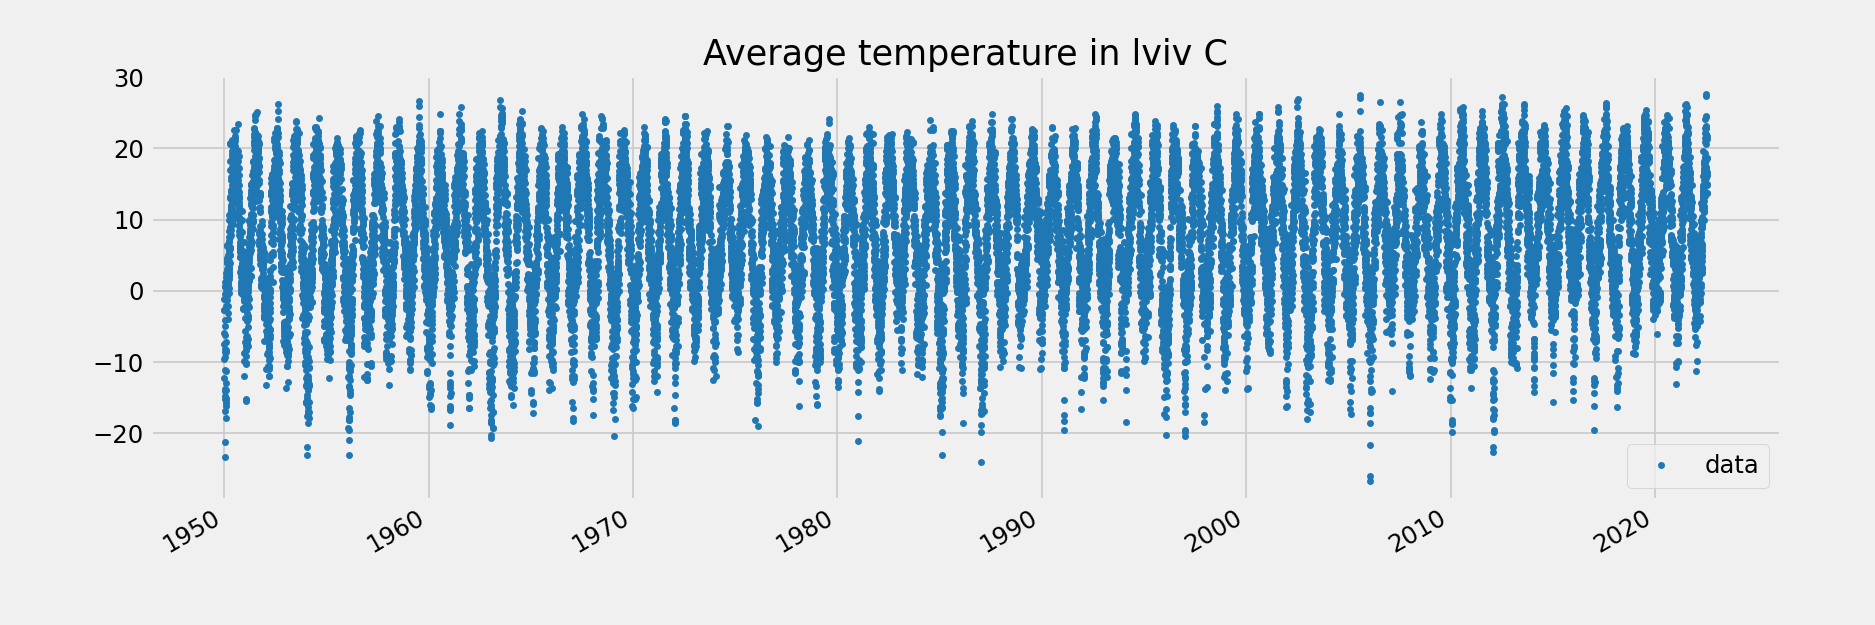

In [14]:
data[["data"]].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Average temperature in lviv C')
plt.show()

# Train / Test Split

<IPython.core.display.Javascript object>


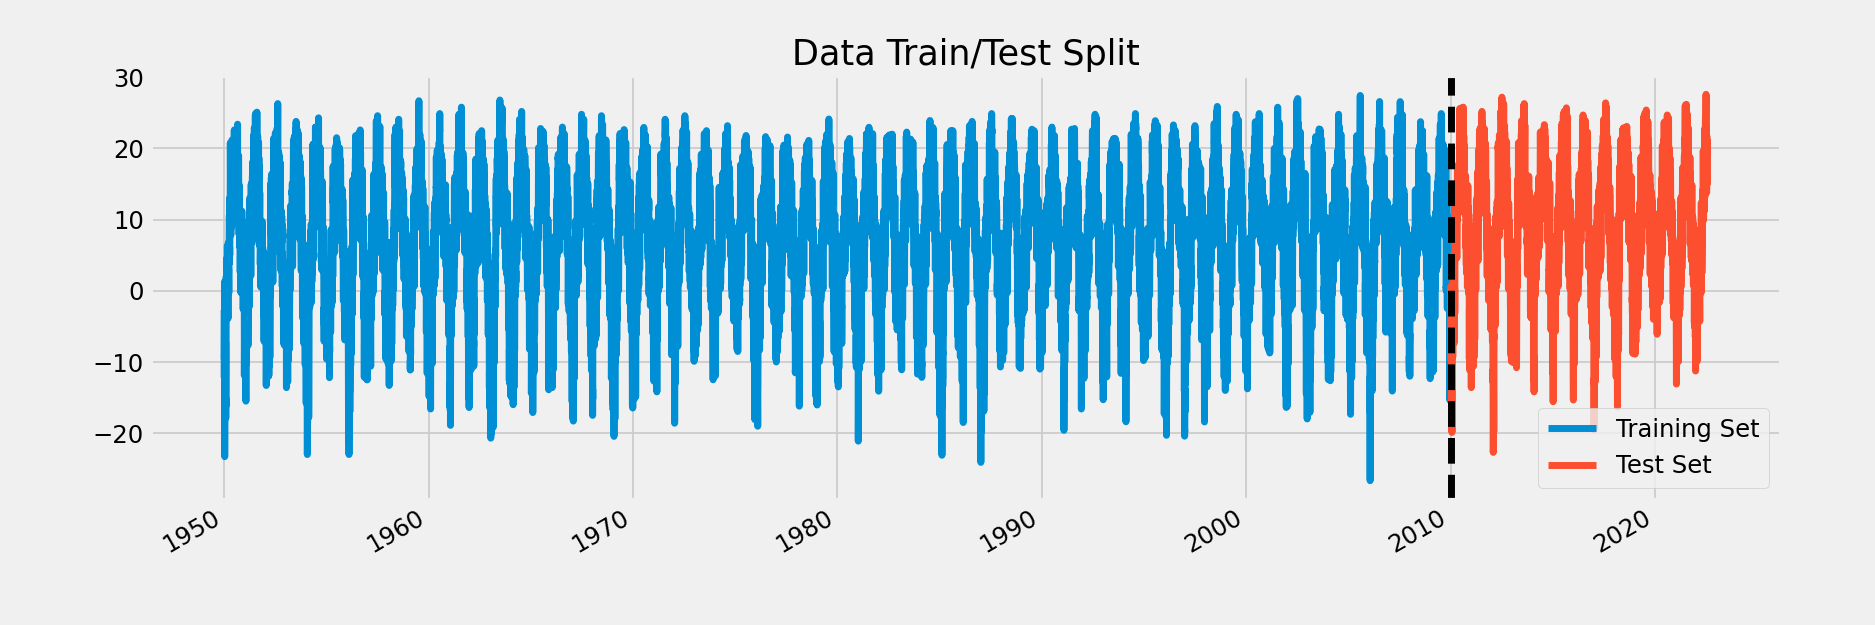

In [15]:
train = data.loc[data.index < '01-01-2010']
test = data.loc[data.index >= '01-01-2010']

fig, ax = plt.subplots(figsize=(15, 5))
train["data"].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test["data"].plot(ax=ax, label='Test Set')
ax.axvline('01-01-2010', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

<IPython.core.display.Javascript object>


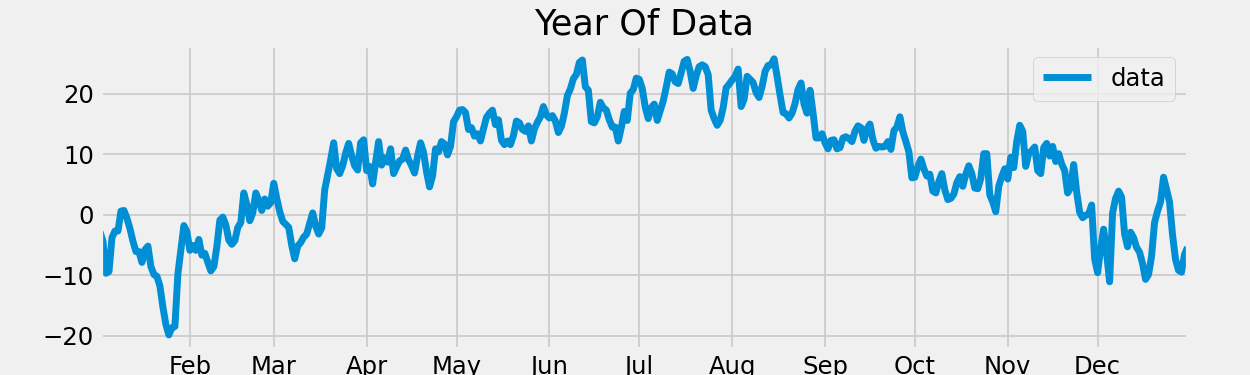

In [26]:
p=data.loc[(data.index > '01-01-2010') & (data.index < '01-01-2011')]
p[["data"]].plot(figsize=(10, 3), title='Year Of Data')
plt.show()

# Feature/Target relationship

<IPython.core.display.Javascript object>


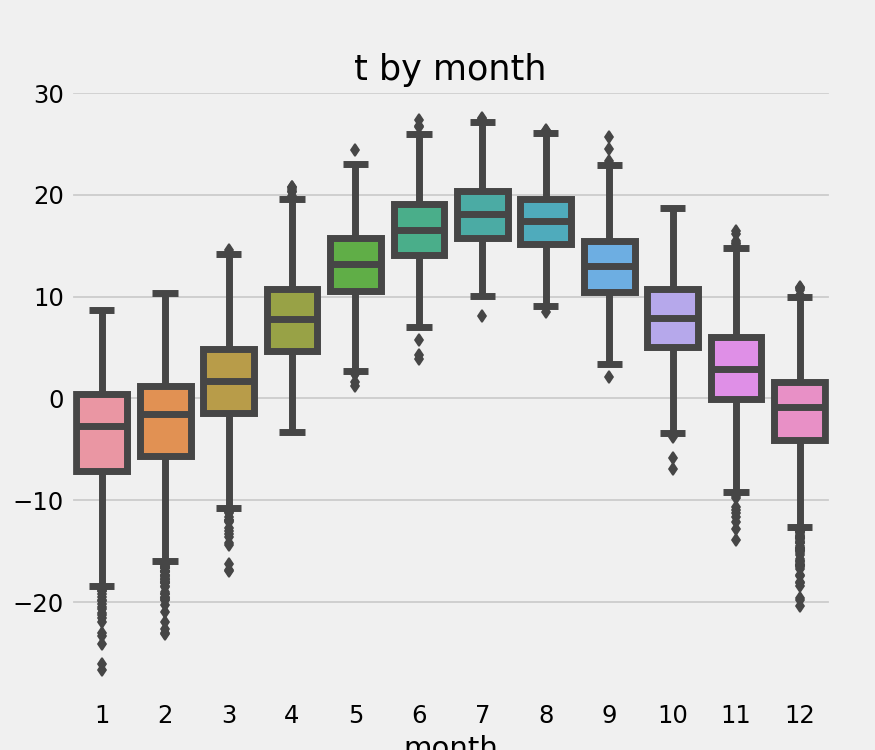

In [17]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(data=data, x='month', y='data')
ax.set_title('t by month')
plt.show()

<IPython.core.display.Javascript object>


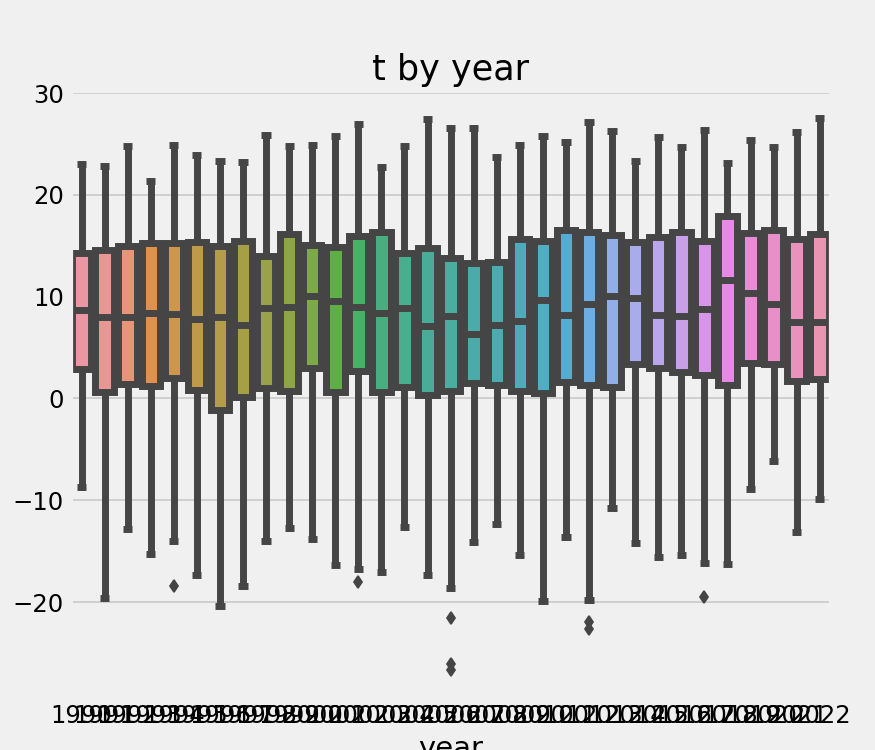

In [74]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(data=data[data.index>'01-01-1990'], x='year', y='data')
ax.set_title('t by year')
plt.show()

<IPython.core.display.Javascript object>


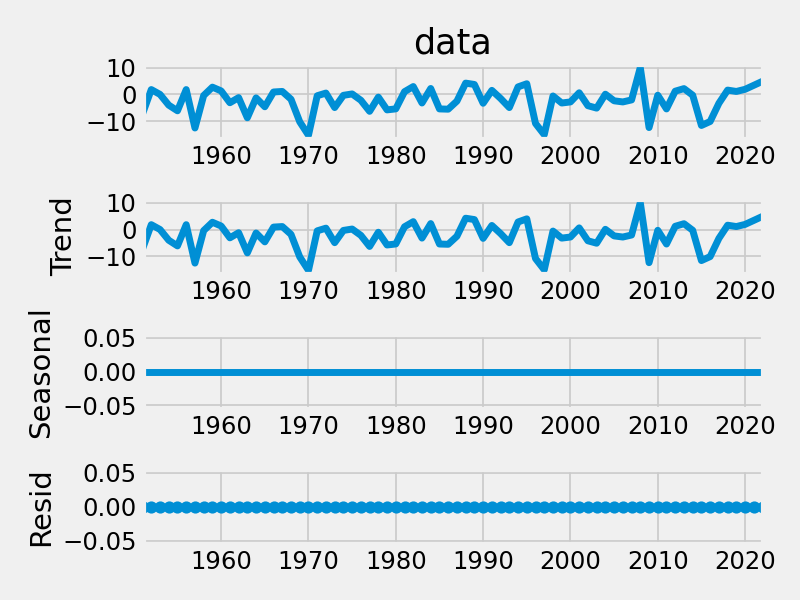

1950-12-31    0.0
1951-12-31    0.0
1952-12-31    0.0
1953-12-31    0.0
1954-12-31    0.0
             ... 
2017-12-31    0.0
2018-12-31    0.0
2019-12-31    0.0
2020-12-31    0.0
2021-12-31    0.0
Freq: A-DEC, Name: seasonal, Length: 72, dtype: float64


In [168]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data["data"].asfreq('Y').fillna(10))
p = result.seasonal
result.plot()
data["data"].asfreq('MS').fillna(0)

In [194]:
data

,year,month,day,element,data,dayofyear,prediction
1950-01-01,1950,1,1,TAVG,-12.2,1,-9.926
1950-01-02,1950,1,2,TAVG,-5.9,2,-7.167
1950-01-03,1950,1,3,TAVG,-2.7,3,-3.802
1950-01-04,1950,1,4,TAVG,-2.7,4,-3.502
1950-01-05,1950,1,5,TAVG,-9.6,5,-7.691
...,...,...,...,...,...,...,...
2022-07-16,2022,7,16,TAVG,16.2,197,17.158
2022-07-17,2022,7,17,TAVG,14.9,198,18.398
2022-07-18,2022,7,18,TAVG,16.7,199,18.656
2022-07-19,2022,7,19,TAVG,18.6,200,19.538


In [195]:
data[["year","month","day","dayofyear","data"]].to_csv("lviv_temp.csv")#, index=False)